In [1]:
from rtergpy.run import defaults, event, etime2name, src2ergs
from rtergpy.waveforms import theorPinfo
from obspy import UTCDateTime
from obspy.core.stream import Stream
Defaults=defaults()
Event=event()
Defaults.src="RASPISHAKE"
Defaults.network="AM"
Defaults.chan="EHZ"

src=Defaults.src
now=UTCDateTime()

 It looks like we are working well now to get data (too much!)

In [2]:
eloc = [18.56,-73.55,10] 
etime= UTCDateTime(2021,8,14,12,29,8) 
Event.ecount='00'
#Event.newData=False   # use already downloaded data
Event.newData=True
Event.eventname=etime2name(etime,ecount=Event.ecount)
Event.origin=[eloc,etime]
Event.focmech=[266, 51, 34] # phi,delta,lmbda

print(Event.eventname)
Defaults.stationrange

2021081400


[25.0, 80.0]

In [3]:
#Event.newData=True
src2ergs(Defaults=Defaults,Event=Event)

Getting waveforms
ERROR:  coudn't move directory to  /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00.bak
Error:  Couldn't create directory:  /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00
Checking for stations available within range from IRIS
Getting waves from RASPISHAKE


  4%|███                                                                         | 31/763 [00:25<11:04,  1.10it/s]

AM.R0A3C.00.EHZ failed to download. Continuing..


  5%|████                                                                        | 41/763 [00:35<09:42,  1.24it/s]

AM.R0CBB.00.EHZ failed to download. Continuing..


  6%|████▍                                                                       | 44/763 [00:37<07:53,  1.52it/s]

AM.R0D06.00.EHZ failed to download. Continuing..


  7%|█████▋                                                                      | 57/763 [00:47<07:30,  1.57it/s]

AM.R10BA.00.EHZ failed to download. Continuing..


  8%|██████▎                                                                     | 64/763 [00:52<07:55,  1.47it/s]

AM.R118B.00.EHZ failed to download. Continuing..


 11%|████████▏                                                                   | 82/763 [01:07<09:17,  1.22it/s]

AM.R17F9.00.EHZ failed to download. Continuing..


 11%|████████▋                                                                   | 87/763 [01:11<09:55,  1.14it/s]

AM.R195D.00.EHZ failed to download. Continuing..


 12%|████████▊                                                                   | 89/763 [01:13<08:11,  1.37it/s]

AM.R1992.00.EHZ failed to download. Continuing..


 13%|█████████▋                                                                  | 97/763 [01:18<07:19,  1.52it/s]

AM.R1F39.00.EHZ failed to download. Continuing..


 14%|██████████▎                                                                | 105/763 [01:24<06:50,  1.60it/s]

AM.R22B6.00.EHZ failed to download. Continuing..


 16%|███████████▊                                                               | 120/763 [01:38<11:13,  1.05s/it]

AM.R269B.00.EHZ failed to download. Continuing..


 19%|█████████████▉                                                             | 142/763 [01:56<06:53,  1.50it/s]

AM.R2C6D.00.EHZ failed to download. Continuing..


 19%|██████████████▏                                                            | 144/763 [01:57<06:27,  1.60it/s]

AM.R2D11.00.EHZ failed to download. Continuing..


 19%|██████████████▎                                                            | 145/763 [01:58<05:57,  1.73it/s]

AM.R2D50.00.EHZ failed to download. Continuing..


 23%|█████████████████                                                          | 173/763 [02:22<08:06,  1.21it/s]

AM.R3542.00.EHZ failed to download. Continuing..


 24%|██████████████████                                                         | 184/763 [02:32<06:29,  1.48it/s]

AM.R3798.00.EHZ failed to download. Continuing..


 24%|██████████████████▏                                                        | 185/763 [02:32<05:54,  1.63it/s]

AM.R379E.00.EHZ failed to download. Continuing..


 25%|██████████████████▉                                                        | 193/763 [02:38<05:59,  1.58it/s]

AM.R3C0B.00.EHZ failed to download. Continuing..


 26%|███████████████████▎                                                       | 196/763 [02:40<06:02,  1.57it/s]

AM.R3C3F.00.EHZ failed to download. Continuing..


 29%|█████████████████████▍                                                     | 218/763 [02:57<06:24,  1.42it/s]

AM.R44BB.00.EHZ failed to download. Continuing..


 29%|█████████████████████▋                                                     | 221/763 [02:59<06:27,  1.40it/s]

AM.R457D.00.EHZ failed to download. Continuing..


 30%|██████████████████████▏                                                    | 226/763 [03:04<07:53,  1.13it/s]

AM.R495F.00.EHZ failed to download. Continuing..


 31%|███████████████████████▎                                                   | 237/763 [03:12<05:40,  1.54it/s]

AM.R4C90.00.EHZ failed to download. Continuing..


 31%|███████████████████████▍                                                   | 238/763 [03:12<05:11,  1.68it/s]

AM.R4CD4.00.EHZ failed to download. Continuing..


 31%|███████████████████████▌                                                   | 240/763 [03:14<05:11,  1.68it/s]

AM.R4DA5.00.EHZ failed to download. Continuing..


 32%|███████████████████████▊                                                   | 242/763 [03:15<04:56,  1.76it/s]

AM.R4DF7.00.EHZ failed to download. Continuing..


 32%|████████████████████████                                                   | 245/763 [03:17<05:11,  1.66it/s]

AM.R4F29.00.EHZ failed to download. Continuing..


 33%|████████████████████████▍                                                  | 248/763 [03:19<05:01,  1.71it/s]

AM.R4FFA.00.EHZ failed to download. Continuing..


 34%|█████████████████████████▎                                                 | 257/763 [03:26<06:48,  1.24it/s]

AM.R533E.00.EHZ failed to download. Continuing..


 35%|██████████████████████████▏                                                | 267/763 [03:36<06:24,  1.29it/s]

AM.R562A.00.EHZ failed to download. Continuing..


 36%|██████████████████████████▊                                                | 273/763 [03:42<06:33,  1.24it/s]

AM.R58E5.00.EHZ failed to download. Continuing..


 37%|███████████████████████████▍                                               | 279/763 [03:46<05:19,  1.52it/s]

AM.R5A68.00.EHZ failed to download. Continuing..


 37%|███████████████████████████▌                                               | 281/763 [03:47<04:58,  1.62it/s]

AM.R5B00.00.EHZ failed to download. Continuing..


 39%|████████████████████████████▉                                              | 295/763 [03:57<05:04,  1.54it/s]

AM.R60A2.00.EHZ failed to download. Continuing..


 40%|█████████████████████████████▋                                             | 302/763 [04:03<05:25,  1.42it/s]

AM.R63B4.00.EHZ failed to download. Continuing..


 40%|██████████████████████████████                                             | 306/763 [04:06<06:04,  1.25it/s]

AM.R649B.00.EHZ failed to download. Continuing..


 41%|███████████████████████████████                                            | 316/763 [04:15<05:11,  1.43it/s]

AM.R69C9.00.EHZ failed to download. Continuing..


 42%|███████████████████████████████▋                                           | 323/763 [04:20<05:04,  1.44it/s]

AM.R6C13.00.EHZ failed to download. Continuing..


 43%|████████████████████████████████▎                                          | 329/763 [04:24<04:51,  1.49it/s]

AM.R6D71.00.EHZ failed to download. Continuing..


 44%|█████████████████████████████████                                          | 336/763 [04:29<04:36,  1.54it/s]

AM.R700A.00.EHZ failed to download. Continuing..


 45%|█████████████████████████████████▍                                         | 340/763 [04:35<07:08,  1.01s/it]

AM.R71E7.00.EHZ failed to download. Continuing..


 45%|██████████████████████████████████                                         | 346/763 [04:39<04:40,  1.49it/s]

AM.R7580.00.EHZ failed to download. Continuing..


 45%|██████████████████████████████████                                         | 347/763 [04:39<04:14,  1.64it/s]

AM.R7586.00.EHZ failed to download. Continuing..


 47%|██████████████████████████████████▉                                        | 356/763 [04:46<04:49,  1.41it/s]

AM.R7971.00.EHZ failed to download. Continuing..


 48%|████████████████████████████████████▎                                      | 369/763 [04:56<04:09,  1.58it/s]

AM.R7D5E.00.EHZ failed to download. Continuing..


 49%|█████████████████████████████████████                                      | 377/763 [05:02<04:11,  1.54it/s]

AM.R7FE6.00.EHZ failed to download. Continuing..


 50%|█████████████████████████████████████▏                                     | 378/763 [05:02<03:50,  1.67it/s]

AM.R7FE8.00.EHZ failed to download. Continuing..


 50%|█████████████████████████████████████▎                                     | 379/763 [05:03<03:34,  1.79it/s]

AM.R800E.00.EHZ failed to download. Continuing..


 50%|█████████████████████████████████████▊                                     | 385/763 [05:09<06:21,  1.01s/it]

AM.R82BD.00.EHZ failed to download. Continuing..


 52%|██████████████████████████████████████▉                                    | 396/763 [05:18<05:30,  1.11it/s]

AM.R87DF.00.EHZ failed to download. Continuing..


 55%|█████████████████████████████████████████▏                                 | 419/763 [05:37<04:06,  1.39it/s]

AM.R8F48.00.EHZ failed to download. Continuing..


 63%|██████████████████████████████████████████████▉                            | 477/763 [06:27<03:10,  1.50it/s]

AM.RA5D4.00.EHZ failed to download. Continuing..


 63%|███████████████████████████████████████████████▎                           | 481/763 [06:29<02:58,  1.58it/s]

AM.RA680.00.EHZ failed to download. Continuing..


 64%|████████████████████████████████████████████████▎                          | 491/763 [06:37<03:14,  1.40it/s]

AM.RA8B1.00.EHZ failed to download. Continuing..


 65%|████████████████████████████████████████████████▋                          | 495/763 [06:40<03:20,  1.33it/s]

AM.RAA2E.00.EHZ failed to download. Continuing..


 66%|█████████████████████████████████████████████████▏                         | 501/763 [06:46<03:37,  1.20it/s]

AM.RAB15.00.EHZ failed to download. Continuing..


 67%|█████████████████████████████████████████████████▉                         | 508/763 [06:51<03:00,  1.41it/s]

AM.RAC78.00.EHZ failed to download. Continuing..


 68%|███████████████████████████████████████████████████                        | 520/763 [07:00<02:46,  1.46it/s]

AM.RAF16.00.EHZ failed to download. Continuing..


 69%|███████████████████████████████████████████████████▋                       | 526/763 [07:04<02:30,  1.57it/s]

AM.RB237.00.EHZ failed to download. Continuing..


 72%|█████████████████████████████████████████████████████▉                     | 549/763 [07:22<02:25,  1.47it/s]

AM.RBAED.00.EHZ failed to download. Continuing..


 74%|███████████████████████████████████████████████████████▍                   | 564/763 [07:35<02:26,  1.35it/s]

AM.RC0D5.00.EHZ failed to download. Continuing..


 76%|████████████████████████████████████████████████████████▉                  | 579/763 [07:47<02:02,  1.50it/s]

AM.RC6A2.00.EHZ failed to download. Continuing..


 77%|█████████████████████████████████████████████████████████▍                 | 584/763 [07:50<01:54,  1.57it/s]

AM.RC8CD.00.EHZ failed to download. Continuing..


 77%|█████████████████████████████████████████████████████████▊                 | 588/763 [07:53<01:52,  1.55it/s]

AM.RCA2F.00.EHZ failed to download. Continuing..


 77%|█████████████████████████████████████████████████████████▉                 | 590/763 [07:54<01:50,  1.57it/s]

AM.RCA40.00.EHZ failed to download. Continuing..


 80%|███████████████████████████████████████████████████████████▋               | 607/763 [08:12<02:28,  1.05it/s]

AM.RD066.00.EHZ failed to download. Continuing..


 81%|████████████████████████████████████████████████████████████▉              | 620/763 [08:22<01:33,  1.53it/s]

AM.RD469.00.EHZ failed to download. Continuing..


 85%|███████████████████████████████████████████████████████████████▍           | 645/763 [08:47<01:33,  1.26it/s]

AM.RDCEE.00.EHZ failed to download. Continuing..


 85%|███████████████████████████████████████████████████████████████▌           | 647/763 [08:49<01:21,  1.42it/s]

AM.RDD5D.00.EHZ failed to download. Continuing..


 86%|████████████████████████████████████████████████████████████████▎          | 654/763 [08:58<01:36,  1.12it/s]

AM.RDF6E.00.EHZ failed to download. Continuing..


 86%|████████████████████████████████████████████████████████████████▌          | 657/763 [09:00<01:27,  1.22it/s]

AM.RE0E2.00.EHZ failed to download. Continuing..


 86%|████████████████████████████████████████████████████████████████▋          | 658/763 [09:01<01:15,  1.39it/s]

AM.RE142.00.EHZ failed to download. Continuing..


 87%|█████████████████████████████████████████████████████████████████          | 662/763 [09:03<01:03,  1.59it/s]

AM.RE28F.00.EHZ failed to download. Continuing..


 88%|█████████████████████████████████████████████████████████████████▉         | 671/763 [09:10<00:57,  1.60it/s]

AM.RE647.00.EHZ failed to download. Continuing..


 92%|████████████████████████████████████████████████████████████████████▋      | 699/763 [09:35<01:32,  1.45s/it]

AM.RF2A7.00.EHZ failed to download. Continuing..


 92%|████████████████████████████████████████████████████████████████████▉      | 701/763 [09:37<01:13,  1.18s/it]

AM.RF562.00.EHZ failed to download. Continuing..


 96%|███████████████████████████████████████████████████████████████████████▉   | 732/763 [10:06<00:20,  1.51it/s]

AM.RFF8E.00.EHZ failed to download. Continuing..


 96%|████████████████████████████████████████████████████████████████████████   | 733/763 [10:06<00:18,  1.66it/s]

AM.S0318.00.EHZ failed to download. Continuing..


 96%|████████████████████████████████████████████████████████████████████████▏  | 734/763 [10:07<00:16,  1.78it/s]

AM.S0320.00.EHZ failed to download. Continuing..


 96%|████████████████████████████████████████████████████████████████████████▎  | 736/763 [10:08<00:15,  1.79it/s]

AM.S0C34.00.EHZ failed to download. Continuing..


 97%|████████████████████████████████████████████████████████████████████████▉  | 742/763 [10:12<00:13,  1.54it/s]

AM.S49FD.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▏ | 745/763 [10:15<00:12,  1.41it/s]

AM.S5754.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▎ | 746/763 [10:15<00:10,  1.57it/s]

AM.S5DF3.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▌ | 748/763 [10:17<00:10,  1.45it/s]

AM.S6498.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▌ | 749/763 [10:17<00:08,  1.60it/s]

AM.S653E.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▋ | 750/763 [10:18<00:07,  1.73it/s]

AM.S6F15.00.EHZ failed to download. Continuing..


 98%|█████████████████████████████████████████████████████████████████████████▊ | 751/763 [10:18<00:06,  1.83it/s]

AM.S791F.00.EHZ failed to download. Continuing..


 99%|██████████████████████████████████████████████████████████████████████████ | 754/763 [10:22<00:10,  1.14s/it]

AM.SAB1A.00.EHZ failed to download. Continuing..


100%|███████████████████████████████████████████████████████████████████████████| 763/763 [10:32<00:00,  1.21it/s]


writing  /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00/pkls/Params_2021081400.pkl 
 /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00/Params_2021081400.csv
writing  /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00/pkls/Wavestream-raw_2021081400.pkl
Working directory now:  /Users/anewman/Documents/Projects/EQerg/rterg_events/events/2021/2021081400/00


/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/run.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf=trdf.append(trstat2pd(tr),ignore_index=True)


Calculating Energy growth with time 
Running fband [0.00333333, 2.0] Hz:


 15%|███████████▎                                                                | 99/666 [00:07<00:47, 12.04it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 15%|███████████▎                                                               | 101/666 [00:07<00:51, 11.08it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 18%|█████████████▍                                                             | 119/666 [00:08<00:41, 13.03it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 21%|███████████████▍                                                           | 137/666 [00:10<00:46, 11.39it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 23%|█████████████████▍                                                         | 155/666 [00:12<00:44, 11.41it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 26%|███████████████████▍                                                       | 173/666 [00:13<00:44, 11.01it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 29%|█████████████████████▌                                                     | 191/666 [00:15<00:42, 11.07it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 31%|███████████████████████▌                                                   | 209/666 [00:16<00:37, 12.24it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 34%|█████████████████████████▌                                                 | 227/666 [00:18<00:36, 12.09it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 37%|███████████████████████████▌                                               | 245/666 [00:20<00:38, 10.91it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 39%|█████████████████████████████▌                                             | 263/666 [00:21<00:34, 11.54it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 42%|███████████████████████████████▋                                           | 281/666 [00:23<00:33, 11.34it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 45%|█████████████████████████████████▋                                         | 299/666 [00:24<00:37,  9.90it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 48%|███████████████████████████████████▋                                       | 317/666 [00:26<00:29, 11.83it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 50%|█████████████████████████████████████▋                                     | 335/666 [00:28<00:30, 10.83it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 53%|███████████████████████████████████████▊                                   | 353/666 [00:29<00:27, 11.48it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 56%|█████████████████████████████████████████▊                                 | 371/666 [00:31<00:27, 10.67it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

 58%|███████████████████████████████████████████▋                               | 388/666 [00:33<00:29,  9.37it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 58%|███████████████████████████████████████████▊                               | 389/666 [00:33<00:29,  9.44it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 61%|█████████████████████████████████████████████▋                             | 406/666 [00:35<00:23, 10.84it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 61%|█████████████████████████████████████████████▉           

 64%|███████████████████████████████████████████████▋                           | 424/666 [00:36<00:22, 10.73it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 64%|███████████████████████████████████████████████▉         

 66%|█████████████████████████████████████████████████▊                         | 442/666 [00:38<00:22,  9.82it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 67%|██████████████████████████████████████████████████       

 69%|███████████████████████████████████████████████████▊                       | 460/666 [00:40<00:21,  9.55it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 69%|████████████████████████████████████████████████████     

 72%|█████████████████████████████████████████████████████▊                     | 478/666 [00:41<00:17, 10.95it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 72%|██████████████████████████████████████████████████████   

 74%|███████████████████████████████████████████████████████▊                   | 496/666 [00:43<00:15, 10.75it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 75%|████████████████████████████████████████████████████████ 

 77%|█████████████████████████████████████████████████████████▉                 | 514/666 [00:45<00:13, 11.14it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 77%|█████████████████████████████████████████████████████████

 80%|███████████████████████████████████████████████████████████▉               | 532/666 [00:47<00:11, 11.34it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 80%|█████████████████████████████████████████████████████████

 83%|█████████████████████████████████████████████████████████████▉             | 550/666 [00:48<00:10, 11.14it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 83%|█████████████████████████████████████████████████████████

 85%|███████████████████████████████████████████████████████████████▉           | 568/666 [00:50<00:12,  8.03it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 86%|█████████████████████████████████████████████████████████

 88%|█████████████████████████████████████████████████████████████████▉         | 586/666 [00:52<00:11,  7.27it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 88%|█████████████████████████████████████████████████████████

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 91%|████████████████████████████████████████████████████████████████████       | 604/666 [00:54<00:06,  9.21it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 91%|█████████████████████████████████████████████████████████

 93%|█████████████████████████████████████████████████████████████████████▊     | 620/666 [00:56<00:04,  9.44it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 93%|█████████████████████████████████████████████████████████

 96%|███████████████████████████████████████████████████████████████████████▋   | 637/666 [00:58<00:02, 10.04it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 96%|███████████████████████████████████████████████████████████████████████▊   | 638/666 [00:58<00:02,  9.88it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 98%|█████████████████████████████████████████████████████████████████████████▌ | 653/666 [01:00<00:01,  8.91it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 98%|█████████████████████████████████████████████████████████████████████████▋ | 654/666 [01:00<00:01,  7.05it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

Running fband [0.5, 2.0] Hz:


 15%|███████████▎                                                               | 100/666 [00:11<01:05,  8.60it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 15%|███████████▎                                                               | 101/666 [00:11<01:07,  8.38it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 17%|█████████████                                                              | 116/666 [00:13<01:10,  7.79it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 18%|█████████████▏                                                             | 117/666 [00:13<01:10,  7.82it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 20%|██████████████▊                                                            | 132/666 [00:16<01:11,  7.50it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 20%|██████████████▉                                                            | 133/666 [00:16<01:37,  5.49it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 22%|████████████████▋                                                          | 148/666 [00:18<01:42,  5.06it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 22%|████████████████▊                                                          | 149/666 [00:18<01:32,  5.59it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 25%|██████████████████▍                                                        | 164/666 [00:20<01:07,  7.38it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 25%|██████████████████▌                                                        | 165/666 [00:21<01:19,  6.33it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 27%|████████████████████▎                                                      | 180/666 [00:23<01:05,  7.39it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 27%|████████████████████▍                                                      | 181/666 [00:23<01:18,  6.17it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 29%|██████████████████████                                                     | 196/666 [00:25<01:00,  7.71it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 30%|██████████████████████▏                                                    | 197/666 [00:25<01:00,  7.80it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 32%|███████████████████████▊                                                   | 212/666 [00:27<01:00,  7.49it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 32%|███████████████████████▉                                                   | 213/666 [00:27<00:59,  7.58it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 34%|█████████████████████████▋                                                 | 228/666 [00:29<00:53,  8.24it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 34%|█████████████████████████▊                                                 | 229/666 [00:29<01:16,  5.68it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 37%|███████████████████████████▍                                               | 244/666 [00:32<01:00,  6.94it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 37%|███████████████████████████▌                                               | 245/666 [00:32<01:00,  6.96it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 39%|█████████████████████████████▎                                             | 260/666 [00:34<01:01,  6.63it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 39%|█████████████████████████████▍                                             | 261/666 [00:34<01:00,  6.64it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 41%|███████████████████████████████                                            | 276/666 [00:37<01:11,  5.44it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 42%|███████████████████████████████▏                                           | 277/666 [00:37<01:05,  5.98it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 44%|████████████████████████████████▉                                          | 293/666 [00:39<00:43,  8.62it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 44%|█████████████████████████████████                        

 46%|██████████████████████████████████▋                                        | 308/666 [00:41<00:49,  7.19it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 46%|██████████████████████████████████▊                                        | 309/666 [00:41<00:49,  7.18it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 49%|████████████████████████████████████▍                                      | 324/666 [00:43<00:41,  8.31it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 49%|████████████████████████████████████▌                                      | 325/666 [00:43<00:40,  8.51it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 51%|██████████████████████████████████████▎                                    | 340/666 [00:45<00:40,  7.98it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 51%|██████████████████████████████████████▍                                    | 341/666 [00:45<00:39,  8.18it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 54%|████████████████████████████████████████▏                                  | 357/666 [00:47<00:32,  9.54it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 54%|████████████████████████████████████████▎                                  | 358/666 [00:47<00:32,  9.42it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 56%|██████████████████████████████████████████                                 | 373/666 [00:49<00:32,  9.10it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 56%|██████████████████████████████████████████                                 | 374/666 [00:49<00:32,  9.04it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 58%|███████████████████████████████████████████▊                               | 389/666 [00:51<00:33,  8.29it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 59%|███████████████████████████████████████████▉                               | 390/666 [00:51<00:32,  8.62it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 61%|█████████████████████████████████████████████▋                             | 406/666 [00:53<00:26,  9.68it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 61%|█████████████████████████████████████████████▊                             | 407/666 [00:53<00:26,  9.62it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 64%|███████████████████████████████████████████████▋                           | 424/666 [00:55<00:24,  9.79it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 64%|███████████████████████████████████████████████▊         

 66%|█████████████████████████████████████████████████▋                         | 441/666 [00:57<00:27,  8.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 66%|█████████████████████████████████████████████████▊                         | 442/666 [00:57<00:26,  8.59it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 69%|███████████████████████████████████████████████████▌                       | 458/666 [00:58<00:21,  9.58it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 69%|███████████████████████████████████████████████████▋                       | 459/666 [00:59<00:27,  7.52it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 71%|█████████████████████████████████████████████████████▍                     | 475/666 [01:00<00:20,  9.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 71%|█████████████████████████████████████████████████████▌                     | 476/666 [01:00<00:20,  9.30it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 74%|███████████████████████████████████████████████████████▌                   | 493/666 [01:03<00:20,  8.37it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

 76%|█████████████████████████████████████████████████████████▎                 | 509/666 [01:04<00:20,  7.67it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 77%|█████████████████████████████████████████████████████████▍                 | 510/666 [01:04<00:19,  8.21it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 79%|███████████████████████████████████████████████████████████▏               | 526/666 [01:06<00:14,  9.72it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 79%|█████████████████████████████████████████████████████████

 82%|█████████████████████████████████████████████████████████████▏             | 543/666 [01:08<00:13,  8.79it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 82%|█████████████████████████████████████████████████████████████▎             | 544/666 [01:08<00:13,  8.99it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 84%|███████████████████████████████████████████████████████████████            | 560/666 [01:10<00:12,  8.74it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 84%|███████████████████████████████████████████████████████████████▏           | 561/666 [01:10<00:11,  8.95it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

 87%|████████████████████████████████████████████████████████████████▉          | 577/666 [01:12<00:12,  6.89it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 87%|█████████████████████████████████████████████████████████

 89%|██████████████████████████████████████████████████████████████████▉        | 594/666 [01:14<00:07,  9.26it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 89%|█████████████████████████████████████████████████████████

 92%|████████████████████████████████████████████████████████████████████▉      | 612/666 [01:16<00:05,  9.10it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 92%|█████████████████████████████████████████████████████████████████████      | 613/666 [01:17<00:06,  8.37it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 95%|██████████████████████████████████████████████████████████████████████▉    | 630/666 [01:18<00:03,  9.91it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
 97%|████████████████████████████████████████████████████████████████████████▉  | 648/666 [01:20<00:01, 10.29it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/s

100%|██████████████████████████████████████████████████████████████████████████▊| 664/666 [01:22<00:00,  9.27it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tempEdf[netstatchan[i]]=Epersec
100%|█████████████████████████████████████████████████████████

Length EBB and EHF 360 360
Calculating TACER Values


 15%|███████████▎                                                               | 100/666 [00:05<00:29, 19.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 15%|███████████▍                             

 18%|█████████████▎                                                             | 118/666 [00:06<00:32, 17.03it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 18%|█████████████▌                           

 20%|███████████████▎                                                           | 136/666 [00:07<00:30, 17.30it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 21%|███████████████▌                         

 23%|█████████████████▎                                                         | 154/666 [00:08<00:29, 17.34it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 23%|█████████████████▌                       

 26%|███████████████████▎                                                       | 172/666 [00:09<00:28, 17.44it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 26%|███████████████████▌                     

 29%|█████████████████████▍                                                     | 190/666 [00:10<00:27, 17.40it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 29%|█████████████████████▌                   

 31%|███████████████████████▍                                                   | 208/666 [00:11<00:26, 17.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 32%|███████████████████████▋                 

 34%|█████████████████████████▍                                                 | 226/666 [00:12<00:25, 17.37it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 34%|█████████████████████████▋               

 37%|███████████████████████████▍                                               | 244/666 [00:13<00:24, 17.38it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 37%|███████████████████████████▋             

 39%|█████████████████████████████▌                                             | 262/666 [00:14<00:23, 17.29it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 40%|█████████████████████████████▋           

 42%|███████████████████████████████▌                                           | 280/666 [00:15<00:22, 17.36it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 42%|███████████████████████████████▊         

 45%|█████████████████████████████████▌                                         | 298/666 [00:17<00:21, 17.36it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 45%|█████████████████████████████████▊       

 47%|███████████████████████████████████▌                                       | 316/666 [00:18<00:20, 17.48it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 48%|███████████████████████████████████▊     

 50%|█████████████████████████████████████▌                                     | 334/666 [00:19<00:18, 17.90it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 50%|█████████████████████████████████████▊   

 53%|███████████████████████████████████████▋                                   | 352/666 [00:20<00:17, 18.11it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 53%|███████████████████████████████████████▊ 

 56%|█████████████████████████████████████████▋                                 | 370/666 [00:21<00:16, 18.48it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 56%|█████████████████████████████████████████

 58%|███████████████████████████████████████████▋                               | 388/666 [00:21<00:14, 18.64it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 59%|█████████████████████████████████████████

 61%|█████████████████████████████████████████████▋                             | 406/666 [00:22<00:13, 18.91it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 61%|█████████████████████████████████████████

 64%|███████████████████████████████████████████████▋                           | 424/666 [00:23<00:12, 18.66it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 64%|█████████████████████████████████████████

 66%|█████████████████████████████████████████████████▊                         | 442/666 [00:24<00:11, 18.87it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 67%|█████████████████████████████████████████

 69%|███████████████████████████████████████████████████▊                       | 460/666 [00:25<00:11, 18.49it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 69%|█████████████████████████████████████████

 72%|█████████████████████████████████████████████████████▊                     | 478/666 [00:26<00:09, 18.80it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 72%|█████████████████████████████████████████

 74%|███████████████████████████████████████████████████████▊                   | 496/666 [00:27<00:08, 19.07it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 75%|█████████████████████████████████████████

 77%|█████████████████████████████████████████████████████████▉                 | 514/666 [00:28<00:07, 19.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 77%|█████████████████████████████████████████

 80%|███████████████████████████████████████████████████████████▉               | 532/666 [00:29<00:06, 19.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 80%|█████████████████████████████████████████

 83%|█████████████████████████████████████████████████████████████▉             | 550/666 [00:30<00:06, 19.33it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 83%|█████████████████████████████████████████

 85%|███████████████████████████████████████████████████████████████▉           | 568/666 [00:31<00:05, 19.00it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 86%|█████████████████████████████████████████

 88%|█████████████████████████████████████████████████████████████████▉         | 586/666 [00:32<00:04, 19.17it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 88%|█████████████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████       | 604/666 [00:33<00:03, 19.09it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 91%|█████████████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████     | 622/666 [00:34<00:02, 19.12it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 94%|█████████████████████████████████████████

 96%|████████████████████████████████████████████████████████████████████████   | 640/666 [00:35<00:01, 19.07it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 96%|█████████████████████████████████████████

 99%|██████████████████████████████████████████████████████████████████████████ | 658/666 [00:36<00:00, 18.83it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 99%|█████████████████████████████████████████

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 17%|████████████▌                                                              | 111/666 [00:04<00:25, 21.38it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 19%|██████████████▌                                                            | 129/666 [00:05<00:26, 20.35it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 22%|████████████████▌                                                          | 147/666 [00:06<00:25, 20.26it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 25%|██████████████████▌                                                        | 165/666 [00:07<00:24, 20.14it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 27%|████████████████████▌                                                      | 183/666 [00:08<00:24, 20.03it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 30%|██████████████████████▋                                                    | 201/666 [00:09<00:23, 20.19it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 33%|████████████████████████▋                                                  | 219/666 [00:10<00:22, 20.28it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 36%|██████████████████████████▋                                                | 237/666 [00:11<00:21, 20.24it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 38%|████████████████████████████▋                                              | 255/666 [00:12<00:20, 20.21it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 41%|██████████████████████████████▋                                            | 273/666 [00:12<00:19, 20.06it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 44%|████████████████████████████████▊                                          | 291/666 [00:13<00:18, 19.89it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 46%|██████████████████████████████████▋                                        | 308/666 [00:14<00:17, 20.17it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 49%|████████████████████████████████████▋                                      | 326/666 [00:15<00:16, 20.13it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 52%|██████████████████████████████████████▋                                    | 344/666 [00:16<00:15, 20.20it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 55%|████████████████████████████████████████▉                                  | 363/666 [00:17<00:15, 19.93it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 57%|██████████████████████████████████████████▊                                | 380/666 [00:18<00:14, 20.02it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 60%|████████████████████████████████████████████▊                              | 398/666 [00:19<00:13, 19.97it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 63%|██████████████████████████████████████████████▉                            | 417/666 [00:20<00:12, 19.63it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 65%|█████████████████████████████████████████████████                          | 436/666 [00:21<00:11, 20.16it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
 68%|███████████████████████████████████████████████████▏                       | 454/666 [00:22<00:10, 19.91it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 71%|█████████████████████████████████████████████████████                      | 471/666 [00:22<00:09, 20.18it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 73%|███████████████████████████████████████████████████████                    | 489/666 [00:23<00:08, 20.33it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 76%|█████████████████████████████████████████████████████████                  | 507/666 [00:24<00:07, 20.19it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 79%|███████████████████████████████████████████████████████████                | 525/666 [00:25<00:06, 20.23it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 82%|█████████████████████████████████████████████████████████████▏             | 543/666 [00:26<00:06, 20.19it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 84%|███████████████████████████████████████████████████████████████▏           | 561/666 [00:27<00:05, 20.13it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 87%|█████████████████████████████████████████████████████████████████▏         | 579/666 [00:28<00:04, 20.19it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 90%|███████████████████████████████████████████████████████████████████▏       | 597/666 [00:29<00:03, 20.08it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 92%|█████████████████████████████████████████████████████████████████████▎     | 615/666 [00:29<00:02, 20.14it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 95%|███████████████████████████████████████████████████████████████████████▎   | 633/666 [00:30<00:01, 20.17it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

 98%|█████████████████████████████████████████████████████████████████████████▎ | 651/666 [00:31<00:00, 20.18it/s]/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tacerout[dEPonly.columns[itr]]=cumerate
/Users/anewman/opt/anaconda3/envs/leah_rtergpy

Median Tacer time = 30.0 -/+ 28.0/45.0 s (25/75th percentile)
From Median Tacer: --------------------------
  Mean BB Energy (Estimated)= 1.43e+16 [Me 7.87]
    1/300 - 2 Hz: 535 traces, 1.43e+16 +- 10^0.37 [J]
    1/2 - 2 Hz: 512 traces, 1.47e+14 +- 10^0.42 [J]
  Mean BB Energy (FM corrected) = 2.37e+16 [Me 8.02]
    1/300 - 2 Hz: 530 traces, 2.37e+16 +- 10^0.39 [J]
    1/2 - 2 Hz: 504 traces, 2.43e+14 +- 10^0.45 [J]
From Per-Station Tacer: ---------------------
  Mean BB Energy (Estimated)= 1.77e+16 [Me 7.93]
    1/300 - 2 Hz: 517 traces, 1.77e+16 +- 10^0.39 [J]
    1/2 - 2 Hz: 493 traces, 2.13e+14 +- 10^0.41 [J]
  Mean BB Energy (FM corrected) = 2.90e+16 [Me 8.08]
    1/300 - 2 Hz: 515 traces, 2.90e+16 +- 10^0.41 [J]
    1/2 - 2 Hz: 483 traces, 3.60e+14 +- 10^0.44 [J]
Making figures



/Users/anewman/opt/anaconda3/envs/leah_rtergpy/lib/python3.9/site-packages/rtergpy/plotting.py:209: RuntimeWarning: divide by zero encountered in log10
  enorm=np.log10(eint/emean)


writing results



### stop here

below are pieces of code used for testing. 

In [4]:
from obspy.clients.fdsn import Client as fdsnClient
from tqdm import tqdm 
from obspy.geodetics.base import gps2dist_azimuth as ll2az
from obspy.geodetics.base import kilometers2degrees as km2d

elat,elon,edep = Event.origin[0]
etime = Event.origin[1]
#etime=UTCDateTime(2022,6,1,12,0,0)
minrad,maxrad = Defaults.stationrange
minrad,maxrad = [25,40]
pwindow=Defaults.waveparams[1]
print(etime,elat,elon)

2021-08-14T12:29:08.000000Z 18.56 -73.55


In [5]:
# below works for getting inventory for RS stations
src='RASPISHAKE'
now=UTCDateTime()
#rsclient = fdsnClient('http://fdsnws.raspberryshakedata.com')
rsclient = fdsnClient(src)
inventory = rsclient.get_stations( network = "AM",
                                 starttime=etime-86400, endtime=etime,
                                 latitude = elat, longitude = elon, 
                                 minradius = minrad, maxradius=maxrad,
                                 channel="EHZ",
                                 level="response")
inventory

Inventory created at 2022-06-13T13:55:54.451016Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (135):
			AM.R0124 (Raspberry Shake Citizen Science Station)
			AM.R0145 (Raspberry Shake Citizen Science Station)
			AM.R01CF (Raspberry Shake Citizen Science Station)
			AM.R0318 (Raspberry Shake Citizen Science Station)
			AM.R03B3 (Raspberry Shake Citizen Science Station)
			AM.R03C7 (Raspberry Shake Citizen Science Station)
			AM.R0A3C (Raspberry Shake Citizen Science Station)
			AM.R0CC0 (Raspberry Shake Citizen Science Station)
			AM.R0F46 (Raspberry Shake Citizen Science Station)
			AM.R0F72 (Raspberry Shake Citizen Science Station)
			AM.R0F8A (Raspberry Shake Citizen Science Station)
			AM.R1148 (Raspberry Shake Citizen Science Station)
			AM.R12C1 (Raspberry Shake Citizen Science Station)
			AM.R14A6 (Raspberry Shake Citizen Science Station)
			AM.R1516 (Raspberry Shake Citizen Science Station)
			AM.R1522 (Raspberry Shake Citizen Scien

In [7]:

def invInRange(inventory,Defaults=Defaults, **kwargs):
    for chan in tqdm(inventory.get_contents().get("channels")):
        slat,slon,sz,sldep=inventory.get_coordinates(chan).values()
        distmeters,az,baz=ll2az(eloc[0],eloc[1],slat,slon)
        delta=km2d(distmeters/1000.)
        minrad,maxrad = Defaults.stationrange
        print(delta,minrad,maxrad)
        #if delta >= minrad and delta <= maxrad:
         
invInRange(inventory,Defaults=Defaults)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 6122.14it/s]

26.42560085849309 25.0 80.0
38.80324249229061 25.0 80.0
34.55804243318568 25.0 80.0
25.19055404970993 25.0 80.0
37.362945447553 25.0 80.0
25.3879111398539 25.0 80.0
26.7635015356203 25.0 80.0
26.34325938066587 25.0 80.0
35.646419777579986 25.0 80.0
29.821962198288027 25.0 80.0
30.80982376387162 25.0 80.0
29.920108731191434 25.0 80.0
25.225798607881103 25.0 80.0
30.33588998086489 25.0 80.0
28.294476740936155 25.0 80.0
29.938328241344337 25.0 80.0
25.173632457236195 25.0 80.0
31.460014188675263 25.0 80.0
29.90263411196873 25.0 80.0
27.89290880565338 25.0 80.0
33.87612519673956 25.0 80.0
39.41169043342974 25.0 80.0
27.085225814017804 25.0 80.0
26.7635015356203 25.0 80.0
25.45610256722269 25.0 80.0
39.771637626308 25.0 80.0
25.292138261640872 25.0 80.0
27.895128163137944 25.0 80.0
25.501914516976957 25.0 80.0
39.54161316819366 25.0 80.0
25.90814461403639 25.0 80.0
29.003552346506048 25.0 80.0
29.427245219122497 25.0 80.0
30.39432611954753 25.0 80.0
39.540589435082836 25.0 80.0
25.267533767

In [9]:
from rtergpy.waveforms import get_respinv
i2=get_respinv(Defaults.network,eloc,etime,Defaults.stationrange,Defaults.chan,src=Defaults.src)

In [10]:
invInRange(i2,Defaults=Defaults)
#theorPinfo(eloc,etime,(-18.57657658, 30.35, 1291.91)) #,(-18.57657658, 30.35791681, 1291.61))

 43%|██████████████████████████████████████████▋                                                        | 329/763 [00:00<00:00, 3286.26it/s]

69.15430877443825 25.0 80.0
48.7388364573542 25.0 80.0
41.49639304120815 25.0 80.0
67.11016368531827 25.0 80.0
26.42560085849309 25.0 80.0
63.96833285332275 25.0 80.0
38.80324249229061 25.0 80.0
71.26894751232473 25.0 80.0
34.55804243318568 25.0 80.0
70.46474045808183 25.0 80.0
78.29288603527556 25.0 80.0
70.51927639453596 25.0 80.0
46.1308270479559 25.0 80.0
25.19055404970993 25.0 80.0
62.25113471950686 25.0 80.0
37.362945447553 25.0 80.0
25.3879111398539 25.0 80.0
71.31418245156019 25.0 80.0
48.960140057888296 25.0 80.0
61.668763831119236 25.0 80.0
42.658814934624466 25.0 80.0
73.66009883835939 25.0 80.0
45.976213591595396 25.0 80.0
42.26669432474708 25.0 80.0
41.88310945998326 25.0 80.0
65.26725978706155 25.0 80.0
62.3879557655531 25.0 80.0
65.12965389305774 25.0 80.0
63.016980647329405 25.0 80.0
48.94838997684925 25.0 80.0
26.7635015356203 25.0 80.0
67.3421990947764 25.0 80.0
48.87252819995644 25.0 80.0
46.293157990327735 25.0 80.0
62.19688763362499 25.0 80.0
75.20700126009105 25.0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:00<00:00, 1868.29it/s]

 25.0 80.0
25.128072824036156 25.0 80.0
64.91974036103802 25.0 80.0
70.44724292915762 25.0 80.0
26.07166842583745 25.0 80.0
42.00013658796169 25.0 80.0
50.207928714571395 25.0 80.0
70.66305396993586 25.0 80.0
73.40980469735392 25.0 80.0
41.686614665399965 25.0 80.0
72.1497760254724 25.0 80.0
42.364041000236035 25.0 80.0
65.464636269515 25.0 80.0
45.881474525242126 25.0 80.0
42.65870130259109 25.0 80.0
69.65457320567833 25.0 80.0
70.57880193211435 25.0 80.0
49.378787757565284 25.0 80.0
49.27656205314639 25.0 80.0
77.15638854994205 25.0 80.0
65.44270605073633 25.0 80.0
66.1108383247371 25.0 80.0
65.464636269515 25.0 80.0
65.29734777690658 25.0 80.0
42.425824553726876 25.0 80.0
29.674773312838752 25.0 80.0
70.5972424098687 25.0 80.0
42.81089768238918 25.0 80.0
45.29267386578103 25.0 80.0
70.40998154234615 25.0 80.0
46.15021759745279 25.0 80.0
26.865177942937223 25.0 80.0
65.464636269515 25.0 80.0
69.5891055317267 25.0 80.0
70.69481418979738 25.0 80.0
49.33797469219495 25.0 80.0
35.0225235

In [11]:
st=Stream()
for chan in tqdm(i2.get_contents().get("channels")):
    slat,slon,sz,sldep=i2.get_coordinates(chan).values()
    sheight=sz-sldep
    sloc=slat,slon,sheight
    distmeters,az,baz=ll2az(eloc[0],eloc[1],slat,slon)
    delta=km2d(distmeters/1000)
#    if delta>=minrad and delta<=maxrad:
    if delta>=minrad and delta<=minrad+10:
        neti,stati,loci,chani=chan.split(".")
        stlocal='' # start with empty field in case first wave fails

        Ptime,Ptoa,Prayp,Pinc,distdeg=theorPinfo(eloc,etime,sloc)
        StartTime=Ptime+pwindow[0]
        EndTime=Ptime+pwindow[1]
        #print(neti, stati,loci,chani,StartTime,EndTime)
        try: 
            #stlocal=rsclient.get_waveforms(neti,stati,loci,starttime=StartTime,endtime=EndTime) 
            stlocal=rsclient.get_waveforms(neti, stati,loci,chani,starttime=StartTime, endtime=EndTime)
            #stlocal=rsclient.get_waveforms(neti,stati,loci,chani,StartTime, EndTime, minimumlength=120, longestonly=True) 

        except:
            print("%s.%s.%s.%s failed to download. Continuing.." %(neti,stati,loci,chani))
        if stlocal:
            # add station coordinates
            print(neti,stati," added")
            stlocal[0].stats.coordinates= {'latitude': slat, 'longitude': slon}
            stlocal[0].stats.distance=distmeters;  # distance should be reported in meters!
            stlocal[0].stats.phasePtime=Ptime;  # UTC time of P-arrival
            stlocal[0].stats.ptoa=Ptoa;  # take-off
            stlocal[0].stats.prayp=Prayp;  # ray parameter
            stlocal[0].stats.pinc=Pinc;  # ray parameter
            stlocal[0].stats.distdeg=distdeg;  # UTC time of P-arrival
            stlocal[0].stats.az=az;  # azimuth
            stlocal[0].stats.baz=baz;  # back-azimuth
            st+=stlocal[0]
            #except:
            #    print ("Channel ", chan, " not added...missing metadata")
        stlocal='' # clear field 
        #else:
            #print("- skip - :", chan)


  1%|▋                                                                                                      | 5/763 [00:00<01:58,  6.38it/s]

AM R0124  added


  1%|█▏                                                                                                     | 9/763 [00:01<02:08,  5.85it/s]

AM R01CF  added


  2%|█▊                                                                                                    | 14/763 [00:02<02:00,  6.24it/s]

AM R0318  added


  2%|██▎                                                                                                   | 17/763 [00:03<02:20,  5.29it/s]

AM R03C7  added


  4%|████▏                                                                                                 | 31/763 [00:03<01:03, 11.55it/s]

AM.R0A3C.00.EHZ failed to download. Continuing..


  6%|█████▌                                                                                                | 42/763 [00:04<00:56, 12.84it/s]

AM R0CC0  added


  6%|██████▌                                                                                               | 49/763 [00:06<02:11,  5.45it/s]

AM R0F8A  added


  8%|████████▎                                                                                             | 62/763 [00:07<01:35,  7.37it/s]

AM R1148  added


  9%|████████▊                                                                                             | 66/763 [00:08<01:49,  6.37it/s]

AM R12C1  added


  9%|█████████▋                                                                                            | 72/763 [00:10<02:18,  4.98it/s]

AM R1516  added


 10%|█████████▊                                                                                            | 73/763 [00:11<02:52,  4.00it/s]

AM R1522  added


 13%|█████████████▏                                                                                       | 100/763 [00:12<00:52, 12.51it/s]

AM R208E  added


 13%|█████████████▌                                                                                       | 102/763 [00:12<01:06,  9.95it/s]

AM R2182  added
AM R21BC  added


 14%|█████████████▊                                                                                       | 104/763 [00:14<01:54,  5.74it/s]

AM R21DC  added


 14%|██████████████▎                                                                                      | 108/763 [00:15<01:54,  5.73it/s]

AM R248D  added


 18%|██████████████████                                                                                   | 136/763 [00:15<00:46, 13.51it/s]

AM R2A2B  added


 19%|███████████████████                                                                                  | 144/763 [00:16<00:46, 13.23it/s]

AM.R2D11.00.EHZ failed to download. Continuing..


 20%|███████████████████▊                                                                                 | 150/763 [00:17<01:01, 10.04it/s]

AM R2E0F  added


 21%|█████████████████████                                                                                | 159/763 [00:18<00:58, 10.31it/s]

AM R30C9  added


 21%|█████████████████████▎                                                                               | 161/763 [00:19<01:11,  8.39it/s]

AM R3118  added


 22%|█████████████████████▊                                                                               | 165/763 [00:20<01:18,  7.63it/s]

AM R33E2  added


 23%|██████████████████████▉                                                                              | 173/763 [00:20<01:02,  9.42it/s]

AM.R3542.00.EHZ failed to download. Continuing..


 23%|███████████████████████▏                                                                             | 175/763 [00:21<01:37,  6.04it/s]

AM R3569  added


 24%|████████████████████████▏                                                                            | 183/763 [00:23<01:33,  6.18it/s]

AM R376A  added


 25%|█████████████████████████▍                                                                           | 192/763 [00:23<01:16,  7.43it/s]

AM R3C08  added


 27%|███████████████████████████▋                                                                         | 209/763 [00:24<00:49, 11.30it/s]

AM R3F94  added


 29%|█████████████████████████████▎                                                                       | 221/763 [00:25<00:39, 13.64it/s]

AM.R457D.00.EHZ failed to download. Continuing..


 30%|██████████████████████████████▌                                                                      | 231/763 [00:25<00:39, 13.63it/s]

AM R4B41  added


 31%|███████████████████████████████▎                                                                     | 237/763 [00:26<00:39, 13.38it/s]

AM.R4C90.00.EHZ failed to download. Continuing..


 32%|███████████████████████████████▉                                                                     | 241/763 [00:28<01:09,  7.50it/s]

AM R4DBF  added


 34%|██████████████████████████████████▌                                                                  | 261/763 [00:29<00:43, 11.62it/s]

AM R53C0  added


 34%|██████████████████████████████████▊                                                                  | 263/763 [00:29<00:53,  9.27it/s]

AM R53EE  added


 35%|███████████████████████████████████▏                                                                 | 266/763 [00:30<01:04,  7.73it/s]

AM R54FE  added


 36%|████████████████████████████████████                                                                 | 272/763 [00:31<01:07,  7.33it/s]

AM R58D7  added


 36%|████████████████████████████████████▍                                                                | 275/763 [00:32<01:18,  6.19it/s]

AM R5936  added


 38%|█████████████████████████████████████▉                                                               | 287/763 [00:33<00:55,  8.58it/s]

AM R5CD0  added


 39%|███████████████████████████████████████▎                                                             | 297/763 [00:34<00:48,  9.52it/s]

AM R610F  added


 41%|█████████████████████████████████████████▏                                                           | 311/763 [00:34<00:37, 12.06it/s]

AM R67E4  added


 42%|██████████████████████████████████████████▏                                                          | 319/763 [00:36<00:46,  9.65it/s]

AM R6A3B  added


 42%|██████████████████████████████████████████▊                                                          | 323/763 [00:37<00:59,  7.39it/s]

AM.R6C13.00.EHZ failed to download. Continuing..


 44%|████████████████████████████████████████████▌                                                        | 337/763 [00:38<00:53,  7.97it/s]

AM R70D4  added


 45%|█████████████████████████████████████████████▌                                                       | 344/763 [00:39<00:54,  7.70it/s]

AM R74C6  added


 46%|██████████████████████████████████████████████                                                       | 348/763 [00:40<01:01,  6.76it/s]

AM R75C2  added


 46%|██████████████████████████████████████████████▊                                                      | 354/763 [00:42<01:04,  6.37it/s]

AM R7813  added


 47%|███████████████████████████████████████████████▊                                                     | 361/763 [00:43<01:09,  5.81it/s]

AM R7A14  added


 48%|████████████████████████████████████████████████▉                                                    | 370/763 [00:44<01:00,  6.51it/s]

AM R7D6A  added


 50%|██████████████████████████████████████████████████                                                   | 378/763 [00:45<00:47,  8.03it/s]

AM.R7FE8.00.EHZ failed to download. Continuing..


 51%|███████████████████████████████████████████████████                                                  | 386/763 [00:46<00:58,  6.39it/s]

AM R82E1  added


 51%|███████████████████████████████████████████████████▊                                                 | 391/763 [00:47<00:58,  6.37it/s]

AM R85C3  added


 51%|███████████████████████████████████████████████████▉                                                 | 392/763 [00:48<01:15,  4.92it/s]

AM R85CD  added


 52%|████████████████████████████████████████████████████▊                                                | 399/763 [00:49<00:59,  6.15it/s]

AM R8842  added


 52%|████████████████████████████████████████████████████▉                                                | 400/763 [00:49<01:16,  4.76it/s]

AM R8897  added


 55%|███████████████████████████████████████████████████████▊                                             | 422/763 [00:50<00:29, 11.60it/s]

AM R8FE8  added


 56%|████████████████████████████████████████████████████████▏                                            | 424/763 [00:51<00:37,  9.13it/s]

AM R903B  added


 56%|████████████████████████████████████████████████████████▋                                            | 428/763 [00:52<00:42,  7.92it/s]

AM R923A  added


 57%|█████████████████████████████████████████████████████████▎                                           | 433/763 [00:52<00:44,  7.37it/s]

AM R93D1  added


 57%|█████████████████████████████████████████████████████████▉                                           | 438/763 [00:53<00:50,  6.50it/s]

AM R94FB  added


 58%|██████████████████████████████████████████████████████████▍                                          | 441/763 [00:54<00:56,  5.69it/s]

AM R95DE  added


 58%|██████████████████████████████████████████████████████████▊                                          | 444/763 [00:55<01:04,  4.93it/s]

AM R9633  added


 60%|████████████████████████████████████████████████████████████▎                                        | 456/763 [00:56<00:37,  8.09it/s]

AM R99EA  added


 62%|██████████████████████████████████████████████████████████████▏                                      | 470/763 [00:57<00:25, 11.36it/s]

AM RA111  added


 62%|██████████████████████████████████████████████████████████████▌                                      | 473/763 [00:58<00:34,  8.52it/s]

AM RA3F2  added


 65%|█████████████████████████████████████████████████████████████████▍                                   | 494/763 [00:58<00:20, 13.42it/s]

AM RAA22  added


 66%|██████████████████████████████████████████████████████████████████▏                                  | 500/763 [00:59<00:21, 12.15it/s]

AM RAB07  added


 67%|███████████████████████████████████████████████████████████████████▊                                 | 512/763 [01:00<00:19, 12.71it/s]

AM RADA1  added


 67%|████████████████████████████████████████████████████████████████████                                 | 514/763 [01:01<00:25,  9.94it/s]

AM RADF8  added


 68%|████████████████████████████████████████████████████████████████████▎                                | 516/763 [01:01<00:31,  7.93it/s]

AM RAE6A  added


 68%|████████████████████████████████████████████████████████████████████▍                                | 517/763 [01:02<00:44,  5.58it/s]

AM RAE96  added


 69%|█████████████████████████████████████████████████████████████████████▏                               | 523/763 [01:06<01:20,  2.98it/s]

AM RB0FA  added


 69%|█████████████████████████████████████████████████████████████████████▎                               | 524/763 [01:07<01:31,  2.62it/s]

AM RB158  added


 70%|██████████████████████████████████████████████████████████████████████▉                              | 536/763 [01:08<00:51,  4.41it/s]

AM RB4AC  added


 71%|████████████████████████████████████████████████████████████████████████▏                            | 545/763 [01:09<00:37,  5.77it/s]

AM RB938  added


 72%|████████████████████████████████████████████████████████████████████████▋                            | 549/763 [01:10<00:34,  6.15it/s]

AM.RBAED.00.EHZ failed to download. Continuing..


 72%|█████████████████████████████████████████████████████████████████████████                            | 552/763 [01:10<00:38,  5.53it/s]

AM RBDC6  added


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 554/763 [01:11<00:43,  4.84it/s]

AM RBE1A  added


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 557/763 [01:12<00:45,  4.53it/s]

AM RBF42  added


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 576/763 [01:13<00:18, 10.02it/s]

AM RC5C2  added


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 592/763 [01:14<00:13, 12.79it/s]

AM RCC41  added


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 610/763 [01:15<00:13, 11.39it/s]

AM RD0D5  added


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 615/763 [01:18<00:24,  6.16it/s]

AM RD2F0  added


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 617/763 [01:19<00:32,  4.44it/s]

AM RD349  added


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 618/763 [01:20<00:37,  3.89it/s]

AM RD399  added


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 632/763 [01:21<00:18,  6.93it/s]

AM RD878  added


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 641/763 [01:22<00:15,  7.75it/s]

AM RDB9A  added


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 642/763 [01:22<00:20,  6.00it/s]

AM RDBE0  added


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 643/763 [01:23<00:25,  4.70it/s]

AM RDC44  added


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 650/763 [01:24<00:19,  5.78it/s]

AM RDEE3  added


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 651/763 [01:25<00:24,  4.55it/s]

AM RDEF4  added


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 652/763 [01:26<00:31,  3.57it/s]

AM RDF0C  added


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 661/763 [01:26<00:17,  5.95it/s]

AM RE241  added


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 663/763 [01:27<00:21,  4.74it/s]

AM RE2AE  added


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 665/763 [01:28<00:24,  4.03it/s]

AM RE349  added


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 667/763 [01:29<00:26,  3.66it/s]

AM RE3C4  added


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 670/763 [01:30<00:24,  3.80it/s]

AM RE594  added


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 683/763 [01:30<00:10,  7.79it/s]

AM REC8C  added


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 689/763 [01:31<00:09,  7.85it/s]

AM REEAC  added


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 695/763 [01:32<00:08,  7.75it/s]

AM RF163  added


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 704/763 [01:33<00:06,  8.96it/s]

AM RF5DA  added


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 706/763 [01:34<00:08,  6.93it/s]

AM RF6B5  added


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 728/763 [01:34<00:02, 13.25it/s]

AM RFD80  added


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 741/763 [01:35<00:01, 14.15it/s]

AM S2768  added


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 743/763 [01:36<00:01, 12.10it/s]

AM.S49FD.00.EHZ failed to download. Continuing..


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 745/763 [01:36<00:01,  9.08it/s]

AM S4C90  added


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [01:37<00:00,  7.81it/s]

AM SAD4C  added


In [35]:
print(st)
        
st2=st.copy()
st2.attach_response(i2)
st2.detrend(type='polynomial', order=5)
st2.taper(0.05)
st2.remove_response(output="VEL")
st2.detrend(type='polynomial', order=5)
st2.taper(0.05)


96 Trace(s) in Stream:

AM.R0124.00.EHZ | 2021-08-14T12:33:44.939999Z - 2021-08-14T12:39:44.939999Z | 100.0 Hz, 36001 samples
...
(94 other traces)
...
AM.SAD4C.00.EHZ | 2021-08-14T12:33:58.249000Z - 2021-08-14T12:39:58.249000Z | 100.0 Hz, 36001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


96 Trace(s) in Stream:

AM.R0124.00.EHZ | 2021-08-14T12:33:44.939999Z - 2021-08-14T12:39:44.939999Z | 100.0 Hz, 36001 samples
...
(94 other traces)
...
AM.SAD4C.00.EHZ | 2021-08-14T12:33:58.249000Z - 2021-08-14T12:39:58.249000Z | 100.0 Hz, 36001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

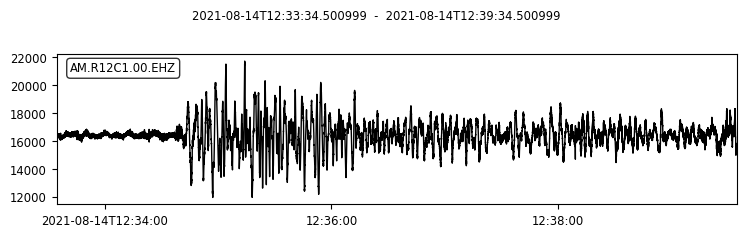

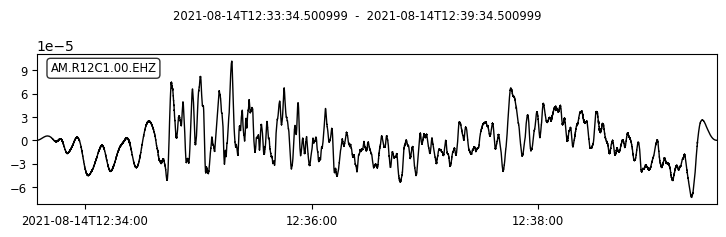

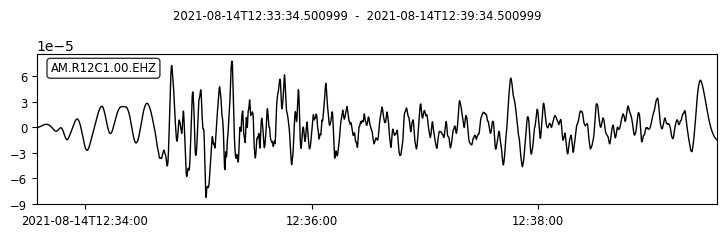

In [36]:
tr0=st[7]
tr2=st2[7]
tr0.plot();
tr2.plot();
tr2.filter("bandpass",freqmin=0.01,freqmax=2)
tr2.plot();
#st[4].stats

In [ ]:
now=UTCDateTime()
rclient = fdsnClient('http://fdsnws.raspberryshakedata.com')
inventory = rclient.get_stations( network = "AM",
                                 minradius = minrad, maxradious = maxrad,
                                 starttime=now-1000, endtime=now,
                                 channel="EHZ",
                                 matchtimeserieTrue,
                                 level="response")
inventory